In [9]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import csv
import corner

First I read the data that has been filtered on "Prelimtransitfit.ipynb" (run first). It contains a folded light curve with time in days and relative flux.

In [10]:
data = pd.read_csv('LCdata.csv')

timeLC = data['Time']
fluxLC = data['Flux']

oot = np.abs(24.0*timeLC) >= 1.1 #points outside of transit
errorLC = np.std(fluxLC[oot])

I define a few properties of the planet and the star, some of them will be fixed during the computations, some others not

In [11]:
## Planet properties
data = pd.read_csv('finaltransitephemeris.csv')
period =  data["Orbital period"][0]

depth = 0.000174 #initial guess
b = 0.5 #initial guess
ecc = 0.0 # fixed because orbital period is very short (circularization)

##Star properties (from Ellen)
mass = 1.00
masserr = 0.04
radius = 1.09
radiuserr = 0.09
u1 = 0.44 #Claret
u2 = 0.24 #Claret
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

Here I define a likelihood function that will help me find the best transit parameters and their uncertainties, in a very similar manner as described in "Prelimtransitfit.ipynb"

In [12]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    
    And the following fixed parameter:
    allfixed[0] = period   orbital period in days
    allfixed[1] = ecc      orbital eccentricity
    allfixed[2] = mass     central value of the stellar mass gaussian prior 
    allfixed[3] = masserr  standard deviation of the stellar mass gaussian prior 
    allfixed[4] = radius     central value of the stellar radius gaussian prior 
    allfixed[5] = radiuserr  standard deviation of the stellar radius gaussian prior 
    allfixed[6] = u1-u2    difference between the limb darkening coefficients 
    allfixed[7] = tKep      cadence of the Kepler observations 
    
    The rest of the inputs are:
    
    timeLC: time from mid-transit in units of days (time series-data)
    fluxLC: normalized stellar flux (time series-data)
    errorLC: first guess for the uncertainty on the stellar fluxes
    """
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius ))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [13]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <1.0) and (0 <= sigma):
        return 0.0
    return -np.inf

In [14]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [15]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [1.2*depth, b, 0.0, 0.0, 0.6, mass, radius, 1.0], 
                     args=(timeLC, fluxLC, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]
u1_ml = 0.5*(sumLD_ml + diffLD)
u2_ml = sumLD_ml-u1_ml

Optimization terminated successfully.
         Current function value: -2485.385335
         Iterations: 547
         Function evaluations: 877


In [16]:
# Compute the light curve integrated over a Kepler long cadence
# exposure time.
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
s.add_body(body)
t = np.arange(-1, 1, tKep*0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f-1.0 + f0_ml

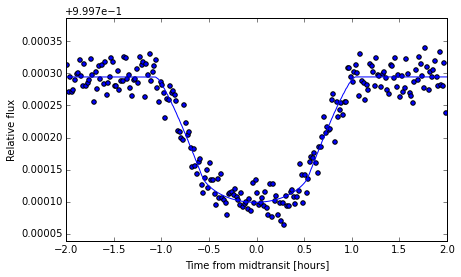

In [17]:
# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*timeLC,fluxLC)
plt.xlim([-2.0, 2.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t, f)

In [18]:
depth_ml, b_ml,  t0_ml, np.sqrt(sigma_ml**2+errorLC**2)

(0.00017137129491417362,
 0.5143512030608629,
 -0.0005778941147197153,
 1.9873126302762155e-05)

With the best fit solution, it is time to run an MCMC routine to estimate the uncertainties on the parameters

In [19]:
ndim, nwalkers = 8, 100
pos = [result["x"]*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [20]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(timeLC, fluxLC, errorLC, allfixed));
sampler.run_mcmc(pos, 1000);

In [21]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

Now I plot the results in a corner plot 

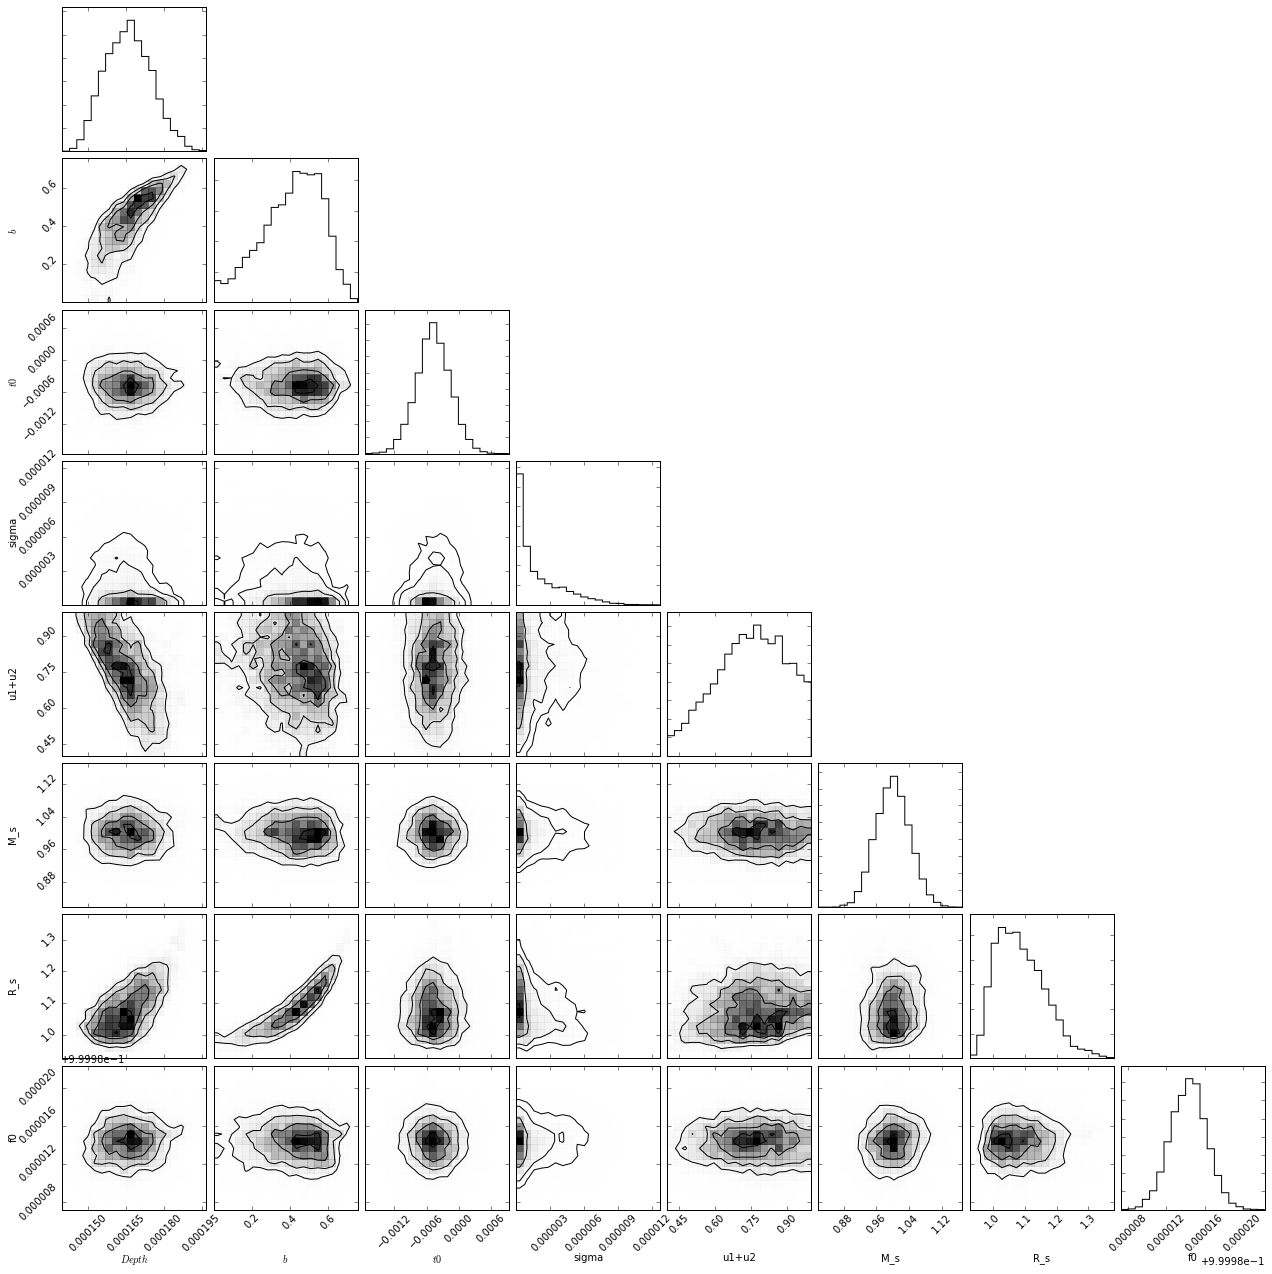

In [22]:
fig = corner.corner(samples, labels=["$Depth$", "$b$", "$t0$", "sigma", "u1+u2", "M_s", "R_s", "f0"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

And here I specifically compute the 50% percentile and the +- 1 sigma error interval of the parameters and some derived quantities

In [23]:
planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]

G = 6.6730e-11
P1 = period*24.0*3600.0
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333 # From stellar density
sineinclsamp = np.sqrt(1.0-(samples[:, 1]*r_asamp)**2)
Kvalsamp = np.random.normal(3.88, 0.9, len(samples[:, 0])) #Comes from RVanalysis folder
mplanetsamp = 317.8*(Kvalsamp/28.4)*samples[:, 5]**(2.0/3.0)*(period/365.25)**(1.0/3.0)*sineinclsamp #From stellar mass

depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: 
                            (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))


v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [16, 50, 84], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(sineinclsamp , [16, 50, 84], axis=0)
sineincl =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(mplanetsamp , [16, 50, 84], axis=0)
mplanet =(v[1], v[2]-v[1], v[1]-v[0])

The planet radius in units of the Earth's radius is:

In [24]:
planetrad_mcmc

(1.5054837966245067, 0.16448572260436478, 0.11566961636817852)

The inverse of the scaled semi-major axis is:

In [25]:
r_a_mcmc

(0.32845257795017063, 0.026468380355821941, 0.020744422900001669)

The mass of the planet too

In [26]:
mplanet

(5.2933638544621608, 1.2362102202399434, 1.2235579568605175)

And here we save the marginalized distributions for the planet mass and radius

In [27]:
f1 = open("Planetproperties.csv", "wb")
ttimes = csv.writer(f1)
ttimes.writerow(["Mass", "Radius"])

for j, mass in enumerate(mplanetsamp):
    entries = [mass, planetradsamp[j]]
    ttimes.writerow(entries)

    
f1.close()

And here we save the final transit parameters with uncertainties

In [28]:
 np.savetxt('finalparameters.txt', (depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc,
                                    radius_mcmc, f0_mcmc, planetrad_mcmc,r_a_mcmc, mplanet), fmt='%.4e', delimiter='   ',
            header = """Parameters obtained from a fit to the Kepler data. The first column represents the 50% percentile
            of the MCMC posterior distribution, whereas the second (third) represents the +1 (-1) sigma uncertainty. In row 
            order, the parameters are: Depth, Impact parameter, time of transit, Flux uncertainty, Sum of LD coefficients, 
            Mass of the star, Radius of the star (gaussian priors on both), out of eclipse flux, Planet radius, R_s/a, planet mass.""") 